[1.0, 1.0, 0.9375, 0.9333333333333333, 0.9285714285714286, 0.9230769230769231, 0.9166666666666666, 0.9090909090909091, 0.9, 0.8888888888888888, 0.875, 0.8571428571428571, 0.8333333333333334, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.998046875, 0.9941291585127201, 0.9901574803149606, 0.9860834990059643, 0.9818548387096774, 0.9774127310061602, 0.9726890756302521, 0.9676025917926566, 0.9620535714285714, 0.9559164733178654, 0.9490291262135923, 0.9411764705882353, 0.9320652173913043, 0.9212827988338192, 0.9082278481012658, 0.89198606271777, 0.87109375, 0.8430493273542601, 0.8031914893617021, 0.7417218543046358, 0.9142857142857144, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.8017601368294395, 0.8553646149564803, 0.8800272573555505, 0.8942554471379669, 0.9033837691748993, 0.909575684214522, 0.913883905934757, 0.9168824641817905, 0.9189087235461993, 0.920170545139108, 0.9207988315012232, 0.9208752120035885, 0.92044

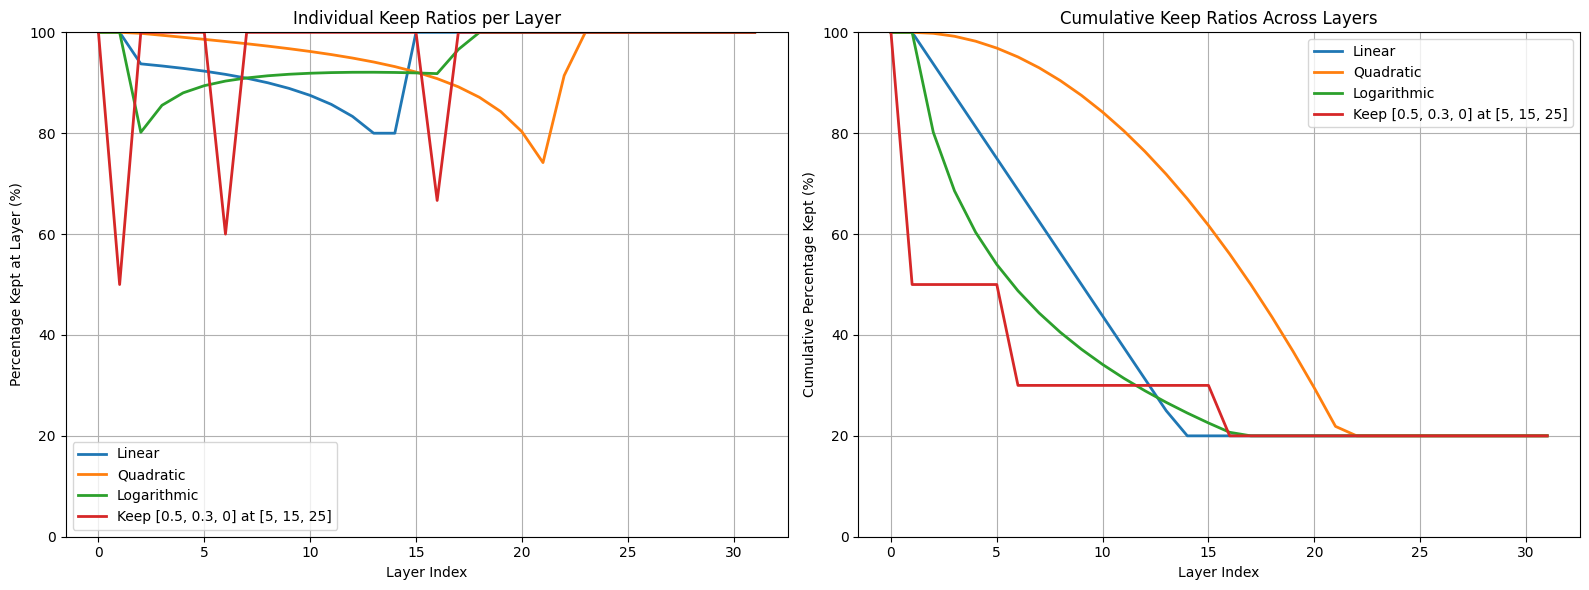

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _calc_cumulative_keep_ratio(f, layer_idx: int, K: int=0, min_keep_ratio: float = 0):
    """Calculate cumulative keep ratio at a given layer."""
    layer_idx = layer_idx - (K-1)
    if layer_idx < 0:
        return 1.0
    layer_prune_ratio = f(layer_idx)
    cumulative_layer_keep_ratio = 1 - layer_prune_ratio
    return max(cumulative_layer_keep_ratio, min_keep_ratio)

def _calc_individual_keep_ratios(f, total_layers, K=0, min_keep_ratio=0):
    """Calculate individual keep ratios from cumulative ratios."""
    individual_keep = []
    prev_cumulative = 1.0
    
    for layer in range(total_layers):
        current_cumulative = _calc_cumulative_keep_ratio(f, layer, K, min_keep_ratio)
        r_k = current_cumulative / prev_cumulative if prev_cumulative > 0 else 0.0
        r_k = max(r_k, min_keep_ratio)
        individual_keep.append(r_k)
        prev_cumulative = current_cumulative
    
    return individual_keep

# Fixed pruning strategy functions
def linear(x, T): return 2 * x / T
def quadratic(x, T): return (x ** 2) / (T ** 2)
def logarithmic(x, T): return np.log(x + 1) / np.log(T + 1)
# def keep_r_at_k(x, r): return (1 - r) if x > 0 else 0  # Returns prune ratio
def prune_r_at_k(x, r_list, k_list):
    """Returns prune ratio at layer x based on specified r and k thresholds.
    
    Args:
        x: Current layer index
        r_list: List of keep ratios for each range
        k_list: List of layer thresholds that define the ranges
        
    Returns:
        Prune ratio (1 - keep_ratio) for the given layer
    """
    # Ensure the thresholds are in ascending order
    sorted_indices = np.argsort(k_list)
    k_list_sorted = np.array(k_list)[sorted_indices]
    r_list_sorted = np.array(r_list)[sorted_indices]
    
    # Iterate through thresholds to find the correct range
    for i in range(len(k_list_sorted)):
        if x < k_list_sorted[i]:
            return 1 - r_list_sorted[i]
    
    # If x is beyond all thresholds, use the last r value
    return 1 - r_list_sorted[-1]

# Parameters
total_layers = 32
layers = np.arange(total_layers)
min_keep_ratio = 0.2
K=2

# Define the r and k values for the keep_r_at_k strategy
r_values = [0.5, 0.3, 0]  # Keep ratios
k_values = [5, 15, 25]      # Layer indices where these apply

strategies = {
    "Linear": lambda x: linear(x, total_layers),
    "Quadratic": lambda x: quadratic(x, total_layers),
    "Logarithmic": lambda x: logarithmic(x, total_layers),
    # "Keep r at k": lambda x: keep_r_at_k(x, 0.5)
    f"Keep {r_values} at {k_values}": lambda x: prune_r_at_k(x, r_values, k_values),
}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot individual keep ratios
for name, strategy in strategies.items():
    individual_ratios = _calc_individual_keep_ratios(strategy, total_layers, K=K, min_keep_ratio=min_keep_ratio)
    ax1.plot(layers, [r * 100 for r in individual_ratios], label=name, linewidth=2)

ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Percentage Kept at Layer (%)')
ax1.set_title('Individual Keep Ratios per Layer')
ax1.legend()
ax1.grid(True)
ax1.set_ylim(0, 100)

# Plot cumulative keep ratios - FIXED VERSION
for name, strategy in strategies.items():
    cumulative_keep = 1.0
    cumulative_ratios = []
    individual_ratios = _calc_individual_keep_ratios(strategy, total_layers, K=K, min_keep_ratio=min_keep_ratio)
    print(individual_ratios)
    for r in individual_ratios:
        cumulative_keep *= r
        cumulative_ratios.append(cumulative_keep * 100)
    
    ax2.plot(layers, cumulative_ratios, label=name, linewidth=2)

ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Cumulative Percentage Kept (%)')
ax2.set_title('Cumulative Keep Ratios Across Layers')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [21]:
import numpy as np

def calc_flops_for_layer(n: int, d: int = 1152, m: int = 18944):
    """Calculate FLOPs for a single transformer layer with n tokens"""
    return (4 * n * d**2) + (2 * n**2 * d) + (2 * n * d * m)

def calculate_total_flops(strategies, total_layers=32, initial_n=100, d=1152, m=18944, K=2, min_keep_ratio=0.0):
    """
    Calculate total FLOPs for different pruning strategies
    
    Args:
        strategies: Dictionary of pruning strategies {name: function}
        total_layers: Total number of layers
        initial_n: Initial number of tokens
        d: Hidden state size
        m: FFN intermediate size
        K: Layer delay before pruning starts
        min_keep_ratio: Minimum keep ratio
        
    Returns:
        Dictionary of total FLOPs for each strategy
    """
    flops_results = {}
    layers = np.arange(total_layers)
    
    for name, strategy in strategies.items():
        total_flops = 0
        n = initial_n  # Start with initial number of tokens
        
        for layer in layers:
            # Get cumulative keep ratio at current layer
            cumulative_keep = _calc_cumulative_keep_ratio(strategy, layer, K, min_keep_ratio)
            
            # Update number of tokens (n_hat = n * cumulative_keep)
            current_n = n * cumulative_keep
            
            # Calculate FLOPs for this layer and add to total
            total_flops += calc_flops_for_layer(current_n, d, m)
            
            # Update n for next layer (if doing cumulative pruning)
            # Note: For independent pruning, you wouldn't update n here
            n = current_n
        
        flops_results[name] = total_flops
    
    return flops_results

# Calculate FLOPs for each strategy
flops_results = calculate_total_flops(
    strategies,
    total_layers=32,
    initial_n=100,  # Starting with 100 tokens
    K=2,           # Start pruning at layer 2
    min_keep_ratio=0.0
)

# Print results in scientific notation
for name, flops in flops_results.items():
    print(f"{name}: {flops:.2e}")

Linear: 2.80e+10
Quadratic: 5.41e+10
Logarithmic: 1.97e+10
Keep [0.5, 0.3, 0] at [5, 15, 25]: 9.73e+09
